In [12]:
import pandas as pd
import matplotlib.pyplot as plt

rep_df = pd.read_csv("/Users/jayhee/Documents/GitHub/Reddit-polarization-project/Republicans_Year.csv")
dem_df = pd.read_csv("/Users/jayhee/Documents/GitHub/Reddit-polarization-project/Democrats_Year.csv")

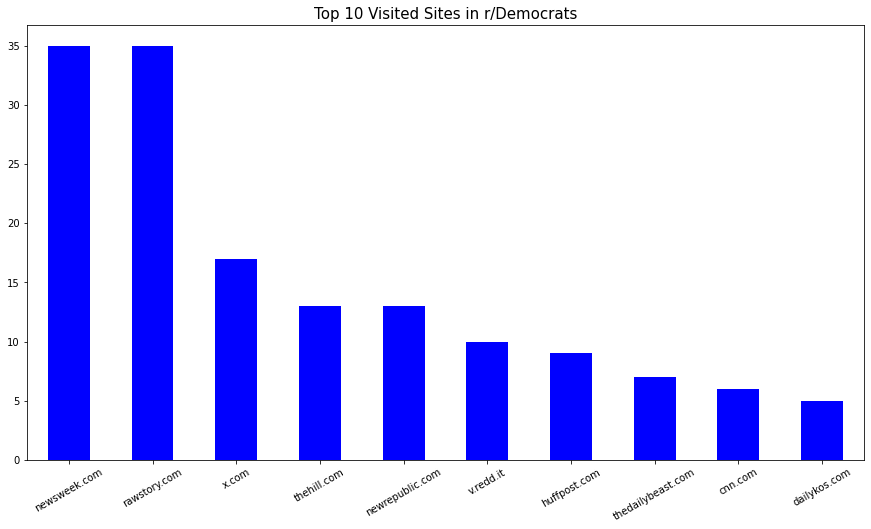

In [16]:
dem_df['sites'] = dem_df.url.apply(lambda x: x.replace('https://www.', '').replace('https://', '').replace('http://', '').split('/')[0])

# number one is reddit, so excluded it to only search for external sources
dem_df.sites.value_counts()[2:12].plot.bar(figsize = (15, 8), rot = 30, color='blue')
plt.title('Top 10 Visited Sites in r/Democrats', fontsize = 15);

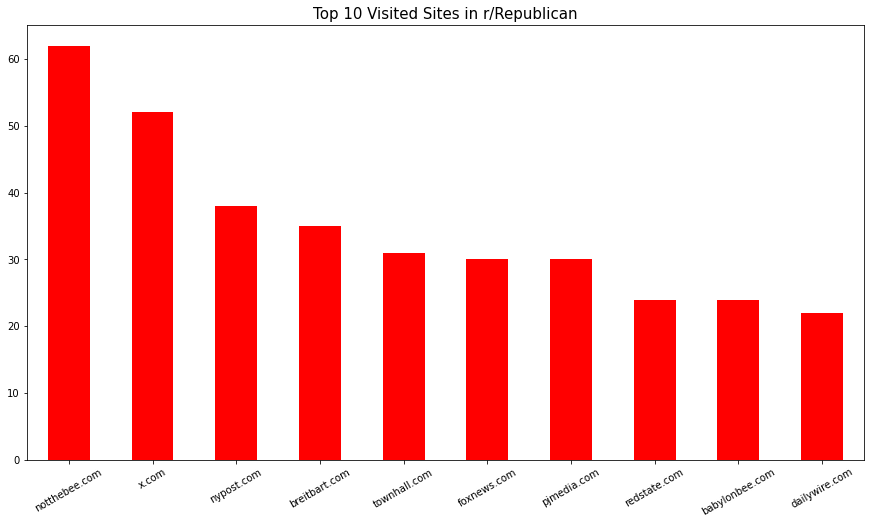

In [17]:
rep_df['sites'] = rep_df.url.apply(lambda x: x.replace('https://www.', '').replace('https://', '').replace('http://', '').split('/')[0])

rep_df.sites.value_counts()[2:12].plot.bar(figsize = (15, 8), rot = 30, color='red')
plt.title('Top 10 Visited Sites in r/Republican', fontsize = 15);